# Table of contents
* [1. Natural Language Processing](#section1)
    * [1.1 Description](#section1.1)
    * [1.2 Features](#section1.2)
        * [1.2.1 Top 50 Features by frequency](#section1.2.1)
    * [1.3 Address](#section1.3)
* [2. Geographic Data](#section2)
    * [2.1 Counties](#section2.1)
    * [2.2 Postal Codes](#section2.2)
    * [2.3 Boroughs](#section2.3)
    * [2.4 Neighborhoods](#section2.4)
* [3. Parks and subways](#section3)
* [4. Managers](#section4)
* [5. Interactions](#section5)
* [6. Transforming 'price'](#section6)
* [7. Finalizing the data and preparation for modeling](#section7)

    


## Importing modules & data

In [1]:
# Standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from mpl_toolkits.mplot3d import axes3d
pd.options.mode.chained_assignment = None
%matplotlib inline

# progress bar for pandas
from tqdm.auto import tqdm
tqdm.pandas() 

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from bs4 import BeautifulSoup
#nltk.download('wordnet')
import re
from scipy.spatial.distance import cdist # for distances
from fuzzywuzzy import fuzz
from scipy import sparse

# Modeling
from sklearn.model_selection import train_test_split
import scipy
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

C:\Users\Annelie Schridde\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
C:\Users\Annelie Schridde\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [58]:
df = pd.read_json(r"C:\Users\Annelie Schridde\Documents\DS Project\cleaned_data.json")
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,interest_level,num_photos,num_features,high_priced,date_created,date_converted,weekday,hour_created,month,dayofmonth
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,1466056527000,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,medium,12,7,0,1466035200000,1466056527000,Thursday,5,6,16
6,1.0,2,b8e75fc949a6cd8225b455648a951712,1464759873000,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,low,6,6,0,1464739200000,1464759873000,Wednesday,5,6,1
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,1465917599000,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,medium,6,6,0,1465862400000,1465917599000,Tuesday,15,6,14


# Feature Engineering

We now proceed with the more creative part. In the following sections we will discuss some ideas for features that we can extract from the already existing columns or possibilities how to transform these. The following sections cover as an example natural language processing and processing of geographic data. At some points we looked into the out-of-bag score to derive if we go with our ideas into the right direction. The following sections include ideas that were partly derived from other Kaggle notebooks as well as own implemented ideas.  

<a id='section1'></a>

## 1. **Natural Language Processing**

The columns 'features', 'description' and 'photos' can be identified as categorical variables. First, we should try to extract the number of list objects and photos out of these columns. This, we have already done in the EDA. Therefore we need to apply the length also for the description.

In [59]:
#changing photos, description and feature to numerical
df['num_description'] = df['description'].apply(lambda x: len(x))

<a id='section1.1'></a>

### 1.1 Description

But let's have a look at the description column again. Here we do not have a list of words, but a whole string.  Looking closely, we can identify there are not only words but also non alphabetical values and probably html code as seen.  As these do not really contribute to the description we might think of excluding them, so that only the words are in the string at last. For this would also need to exclude punctuation. 
Another point is that in the English language are general words that have no true value such as "and" and "the". These are called stop words and should maybe also removed from the actual description leaving the output only with the main aspects of the description.

In [60]:
df['description'][35101]

"3RD FLOOR UNIT IS BRIGHT, QUIET, AND AND SIMPLY A GOOD FIND; GREAT SHARE OR FOR SMALL FAMILY;  SEE ASAP AND CREATE YOU SUMMER MOVE-IN NYC HOME ON THIS CUTE BLOCK CLOSE TO RIVERSIDE PARK, CENTRAL PARK, MORNING SIDE PARK, COLUMBIA, WITH GREAT MARKETS AND CAFES NEARBY;  DON'T HESITATE TO VIEW AND SECURE;  call/text to see and secure with preferred rate available before 6.23.16  --   378-429-2492 Edward<br /><br /><br /><br /><br /><br /><p><a  website_redacted "

From this example we can also see that obviously some of the websites were redacted. Maybe we can put this information as a dummy for our model since re-edited websites might have an influence of the perception of an inquiery. 

In [61]:
# is the description redacted by the website?        
df['num_redacted'] = df['description'].apply(lambda x: 1 if 'website_redacted' in x else 0 )


Now we should go back to our main idea. We should think of how to exclude of the unecessary signs and words. There are several packages that come in handy when processing text data. In the following, different functions were used to clean the description data. 

In [62]:
# stop words
def remove_stop(text):
    words = [w for w in text if w.lower() not in stopwords.words('english')]
    return words

In [63]:
# Non-alphabetic characters
def remove_nonalpha(text):
    no_alpha = re.sub("[^a-zA-Z]"," ", str(text))
    return no_alpha

In [64]:
# Punctuation
import string
def remove_punct(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

In [65]:
# Html
def remove_html(text):
    soup = BeautifulSoup(text, 'lxml')
    html_free = soup.get_text()
    return html_free

In [66]:
# Tokenize ---->  seperate words within string
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [67]:
# Lemmatizing  ---> used for finding word stem (e.g. eaten becomes eat)
lemmatizer = WordNetLemmatizer()

def word_lemma(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

### WARNING! Takes long to run!

Let us apply these functions to finally clean the data and then look at the description again.

In [68]:

df['cleaned_description'] = df['description'].apply(lambda x: remove_html(x))
df['cleaned_description'] = df['cleaned_description'].apply(lambda x: remove_nonalpha(x))
df['cleaned_description'] = df['cleaned_description'].apply(lambda x: remove_punct(x))
df['cleaned_description'] = df['cleaned_description'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['cleaned_description'] = df['cleaned_description'].apply(lambda x: remove_stop(x)) # remove stop words
df['cleaned_description']= df['cleaned_description'].apply(lambda x: word_lemma(x))

C:\Users\Annelie Schridde\anaconda3\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


From now we cleaned the actual description to only count the actual words that are of interest. In the following output we can see that we succesfully removed everything unecessary and are left with the main words of the description. Unfortunately, some words like "3rd" were reduced to "rd". But since these are more or less exceptions, we do not exclude them any further. 

In [69]:
df['cleaned_description'][35101]

['rd',
 'floor',
 'unit',
 'bright',
 'quiet',
 'simply',
 'good',
 'find',
 'great',
 'share',
 'small',
 'family',
 'see',
 'asap',
 'create',
 'summer',
 'move',
 'nyc',
 'home',
 'cute',
 'block',
 'close',
 'riverside',
 'park',
 'central',
 'park',
 'morning',
 'side',
 'park',
 'columbia',
 'great',
 'market',
 'cafe',
 'nearby',
 'hesitate',
 'view',
 'secure',
 'call',
 'text',
 'see',
 'secure',
 'preferred',
 'rate',
 'available',
 'edward']

Let us apply the length of the cleaned description.

In [227]:
df['len_cleaned_description'] = df['cleaned_description'].apply(lambda x: len(x))

From the description we can also extract the information whether a person from renthop left their phone number or e-mail adress. As this might enhance the chance that someone is willing to rent because it seems more trustworthy and direct contact is possible, we will include these features as dummies. 

In [71]:
df['phone'] = df['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x > 0 else 0)
df['email'] = df['description'].apply(lambda x: 1 if '@renthop.com' in x else 0)


<a id='section1.2'></a>

### 1.2 **Features**

Let's also look at the features column. Here we have a list of objects. These objects are strings, for example 'cats allowed'. 

In [72]:
df['features'][600]

['Pre-War', 'Dogs Allowed', 'Cats Allowed']

Since there are words are not spelled in the same way, we need to clean the language. For this we created a loop that runs over every row and each element of the list of the row. It will then only allow lower case words. 
As an example 'Prewar' and 'prewar' will become automatically the same. 

In [73]:
df['features_lower'] = 0
for row in df.index:
    list = []
    for i in range(len(df['features'][row])):
        string = ((df['features'][row][i]).lower()) #each element in list of particular row
        list.append(string)
    df['features_lower'][row] = list
    


df[['features','features_lower']]

,features,features_lower
4,"[Dining Room, Pre-War, Laundry in Building, Di...","[dining room, pre-war, laundry in building, di..."
6,"[Doorman, Elevator, Laundry in Building, Dishw...","[doorman, elevator, laundry in building, dishw..."
9,"[Doorman, Elevator, Laundry in Building, Laund...","[doorman, elevator, laundry in building, laund..."
10,[],[]
15,"[Doorman, Elevator, Fitness Center, Laundry in...","[doorman, elevator, fitness center, laundry in..."
...,...,...
124000,"[Elevator, Dishwasher, Hardwood Floors]","[elevator, dishwasher, hardwood floors]"
124002,"[Common Outdoor Space, Cats Allowed, Dogs Allo...","[common outdoor space, cats allowed, dogs allo..."
124004,"[Dining Room, Elevator, Pre-War, Laundry in Bu...","[dining room, elevator, pre-war, laundry in bu..."
124008,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...","[pre-war, laundry in unit, dishwasher, no fee,..."


Now we have every string in lower case. But unfortunately, there is not only 'prewar' but also 'pre-war' with a hyphen. Also we want every feature to be bound by a "_" to indicate that this is one feature and we can use it for further processing. We, again, created a loop that goes over every row but also every instance within the list per row to transform the instances.

In [74]:
df['cleaned_features'] = 0

for row in df.index:
    ls_feature = []
    for i in range(len(df['features_lower'][row])):
        if " " in df['features_lower'][row][i]:
            new = "_".join(df['features_lower'][row][i].split(" "))
            ls_feature.append(new)
        elif "-" in df['features_lower'][row][i]:
            new = "_".join(df['features_lower'][row][i].split("-"))
            ls_feature.append(new)
        else:
            new = df['features_lower'][row][i]
            ls_feature.append(new)
        
    df['cleaned_features'][row] = ls_feature

In [75]:
df["cleaned_features"]

4         [dining_room, pre_war, laundry_in_building, di...
6         [doorman, elevator, laundry_in_building, dishw...
9         [doorman, elevator, laundry_in_building, laund...
10                                                       []
15        [doorman, elevator, fitness_center, laundry_in...
                                ...                        
124000              [elevator, dishwasher, hardwood_floors]
124002    [common_outdoor_space, cats_allowed, dogs_allo...
124004    [dining_room, elevator, pre_war, laundry_in_bu...
124008    [pre_war, laundry_in_unit, dishwasher, no_fee,...
124009    [dining_room, elevator, laundry_in_building, d...
Name: cleaned_features, Length: 49352, dtype: object

In [609]:
features = df["cleaned_features"].apply(lambda x: " ".join(x))

In [610]:
features

4         dining_room pre_war laundry_in_building dishwa...
6         doorman elevator laundry_in_building dishwashe...
9         doorman elevator laundry_in_building laundry_i...
10                                                         
15        doorman elevator fitness_center laundry_in_bui...
                                ...                        
124000                  elevator dishwasher hardwood_floors
124002    common_outdoor_space cats_allowed dogs_allowed...
124004    dining_room elevator pre_war laundry_in_buildi...
124008    pre_war laundry_in_unit dishwasher no_fee outd...
124009    dining_room elevator laundry_in_building dishw...
Name: cleaned_features, Length: 48848, dtype: object

<a id='section1.2.1'></a>

### 1.2.1 Top 50 features by frequency

Now that we have cleaned our features and joined them via a space again, we can run the Tfidf (term-frequency times inverse document-frequency) vectorizer. It counts how many times a certain feature occurs within the inpt and then normalizes the count. We end up with a matrix of every feature for every row. We here set the maximum of features to 50 to prevent our model to become too big.  

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
columns = df.columns.values

vectorizer = TfidfVectorizer( stop_words='english',  max_features=50) # only 50 features as ouput
X = vectorizer.fit_transform(features)

In [78]:
x_df = pd.DataFrame.sparse.from_spmatrix(X, columns = vectorizer.vocabulary_) # change to DatFrame

In [79]:
x_df.index = df.index # index should be the same

In [80]:

df = pd.concat([df,x_df], axis = 1) # put DataFrames together


In [616]:
df

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,geo,geolocation,county,postal,boroughs,neighborhood,park,subway,sqrt_price,log_price
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,1466056527000,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,"40.7108,-73.9539","[145, Borinquen Place, Williamsburg, Brookl...",Kings County,11211,Brooklyn,other,0,0,48.989795,7.783224
6,1.0,2,b8e75fc949a6cd8225b455648a951712,1464759873000,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,"40.7513,-73.9722","[230, East 44th Street, Turtle Bay, Manhatt...",New York County,10017,Manhattan,Manhattan Community Board 6,1,0,61.644140,8.242756
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,1465917599000,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,"40.7575,-73.9625","[405, East 56th Street, Midtown East, Manha...",New York County,10022,Manhattan,Manhattan Community Board 6,0,0,59.118525,8.159089
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,1466754864000,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,"40.7145,-73.9425","[792, Metropolitan Avenue, Brooklyn, Kings ...",Kings County,11211,Brooklyn,other,0,0,54.772256,8.006368
15,1.0,0,bfb9405149bfff42a92980b594c28234,1467085823000,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,...,"40.7439,-73.9743","[340, East 34th Street, Kips Bay, Manhattan...",New York County,10016,Manhattan,Manhattan Community Board 6,0,0,52.867760,7.935587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,1459828713000,There is 700 square feet of recently renovated...,W 171 Street,"[Elevator, Dishwasher, Hardwood Floors]",40.8433,6824800,-73.9396,...,"40.8433,-73.9396","[620, West 171st Street, Washington Heights,...",New York County,10032,Manhattan,Manhattan Community Board 12,0,1,52.915026,7.937375
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,1459563931000,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.8198,6813268,-73.9578,...,"40.8198,-73.9578","[3333 Broadway, 3333, Broadway, Manhattanvi...",New York County,10115,Manhattan,Manhattan Community Board 9,0,0,48.938737,7.781139
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,1461649323000,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[Dining Room, Elevator, Pre-War, Laundry in Bu...",40.6404,6927093,-73.9554,...,"40.6404,-73.9554","[1221, Flatbush Avenue, Brooklyn, Kings Cou...",Kings County,11226,Brooklyn,other,0,0,43.011626,7.522941
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,1461034053000,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...",40.7448,6892816,-74.0017,...,"40.7448,-74.0017","[348, West 21st Street, Chelsea, Manhattan ...",New York County,10011,Manhattan,Manhattan Community Board 4,1,0,64.768820,8.341649


We can now see the different features as a single column. The result will be a float if this feature is within this column. 

<a id='section1.3'></a>

## 1.3 Address

As we have two address columns in the data set we might want to check if these are actually the same or if there are differences. Customers could think this entry would be a fraud and lose interest. Therefore, we should add a new column that also measures the similarity between the two addresses. One example if the fuzzywuzzy package. With this we can use a fuzzy string match to calculate the partial ratio of similarity. The following datacamp tutorial helped understanding the topic further: https://www.datacamp.com/community/tutorials/fuzzy-string-python. 

In [82]:
df[['display_address', 'street_address']]

,display_address,street_address
4,145 Borinquen Place,145 Borinquen Place
6,East 44th,230 East 44th
9,East 56th Street,405 East 56th Street
10,Metropolitan Avenue,792 Metropolitan Avenue
15,East 34th Street,340 East 34th Street
...,...,...
124000,W 171 Street,620 W 171 Street
124002,Broadway,3333 Broadway
124004,210 Brighton 15th St,210 Brighton 15th St
124008,West 21st Street,350 West 21st Street


In [83]:
df['similarity_address'] = 0.0 #initiate float variable
for row in df.index:
    df['similarity_address'][row] = fuzz.partial_ratio(df['display_address'][row].lower(),df['street_address'][row].lower())

<a id='section3'></a>

Before we can go on we could check wther what we've done was actuall helpful. One idea is it to use the out-of-bag score with a random forest classifier. 
Here we can see that the results increased a bit. with our natural language processing. 

In [130]:
X, y = df.drop(columns = [ 'building_id', 'created', 'description',
       'display_address', 'features', 'listing_id','manager_id',
        'photos',  'street_address', 'interest_level',
       'date_created','date_converted', 'weekday','cleaned_description',
        'features_lower', 'cleaned_features']), df['interest_level']
rf = RandomForestClassifier(n_estimators=100,
                           n_jobs=-1,        # parallelize
                           oob_score=True)   # get error estimate
rf.fit(X, y)
clean_oob_r2 = rf.oob_score_
print(f"Validation OOB score {clean_oob_r2:.4f}")

Validation OOB score 0.7255


## 3. **Geographic Data**

Let us look into the geographic data again. With the help of the geocoder we can reverse geocode with the longitude and latitude. Following article was a great help to understand how this can be coded https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6. From this we should be able to extract different areas from NYC. 

In [98]:
df['geo'] = df['latitude'].map(str) + ',' + df['longitude'].map(str)
df['geo'][4]

'40.7108,-73.9539'

In [99]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent='Google', timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

### WARNING! Code takes long to run!

In [100]:
from tqdm.auto import tqdm
tqdm.pandas()

df['geolocation'] = df['geo'].progress_apply(rgeocode)
df.head()

C:\Users\Annelie Schridde\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,high_ceilings,high_ceiling,laundry_room,renovated,dryer_in_unit,live_in_super,green_building,similarity_address,geo,geolocation
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,1466056527000,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,"40.7108,-73.9539","(145, Borinquen Place, Williamsburg, Brooklyn,..."
6,1.0,2,b8e75fc949a6cd8225b455648a951712,1464759873000,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,"40.7513,-73.9722","(230, East 44th Street, Turtle Bay, Manhattan ..."
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,1465917599000,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,"40.7575,-73.9625","(405, East 56th Street, Midtown East, Manhatta..."
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,1466754864000,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,"40.7145,-73.9425","(792, Metropolitan Avenue, Brooklyn, Kings Cou..."
15,1.0,0,bfb9405149bfff42a92980b594c28234,1467085823000,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,"40.7439,-73.9743","(340, East 34th Street, Kips Bay, Manhattan Co..."


In [104]:
df['geolocation'][600] #check if everything went well

Location(228, East 84th Street, Yorkville, Manhattan Community Board 8, Manhattan, New York County, New York, 10028, United States, (40.77680105, -73.95371052251772, 0.0))

As we can see here in the above example, we were able to extract the whole information of the the location. Let us see what we can do with that address.

In [106]:
df['geolocation'] = df['geolocation'].progress_apply(lambda x: (x.address))

In [111]:
df['geolocation'] = df['geolocation'].progress_apply(lambda x: (x.split(',')))

In [112]:
df['geolocation']

4         [145,  Borinquen Place,  Williamsburg,  Brookl...
6         [230,  East 44th Street,  Turtle Bay,  Manhatt...
9         [405,  East 56th Street,  Midtown East,  Manha...
10        [792,  Metropolitan Avenue,  Brooklyn,  Kings ...
15        [340,  East 34th Street,  Kips Bay,  Manhattan...
                                ...                        
124000    [620,  West 171st Street,  Washington Heights,...
124002    [3333 Broadway,  3333,  Broadway,  Manhattanvi...
124004    [1221,  Flatbush Avenue,  Brooklyn,  Kings Cou...
124008    [348,  West 21st Street,  Chelsea,  Manhattan ...
124009    [123,  East 54th Street,  Midtown East,  Manha...
Name: geolocation, Length: 49350, dtype: object

In [113]:
df['geolocation'][600]

['228',
 ' East 84th Street',
 ' Yorkville',
 ' Manhattan Community Board 8',
 ' Manhattan',
 ' New York County',
 ' New York',
 ' 10028',
 ' United States']

In the follwoing ouput we can see that there are some 'mistakes'. Unfortunately, sometimes the address also involves stores or restaurants which appear as the first index of the list of the geolocation data. For these we are not able to filter them out and have trop everythin that is not correct.

In [114]:
df['geolocation'].apply(lambda x: x[-3:][0]).value_counts() # most listings are from New York. Let us clean that data

 New York           49253
 New Jersey            40
Kings County           31
 New York County       17
 Kings County           7
 Hudson County          1
Queens County           1
Name: geolocation, dtype: int64

<a id='section3.1'></a>

### 3.1 Counties

One idea is to extract the seen counties. We can drop everthig that was not in the right index order as we need the data to be. Therefore everything will be dropped that is not ' New York'.

In [129]:
df = df[df['geolocation'].apply(lambda x: x[-3:][0] == ' New York' )] # keep only New York

df['geolocation'].apply(lambda x: x[-4:][0]).value_counts() 

 New York County                                             42055
 Kings County                                                 4498
 Queens County                                                2044
 Bronx County                                                  359
 Hudson County                                                 290
 New York City Housing Authority Pelham Community Housing        4
 St. Andrews Village                                             2
 Mill Brook Houses                                               1
Name: geolocation, dtype: int64

As we can see we are only left with the New York State counties. Maybe we could see if there is difference within the interest level for the different counties. 

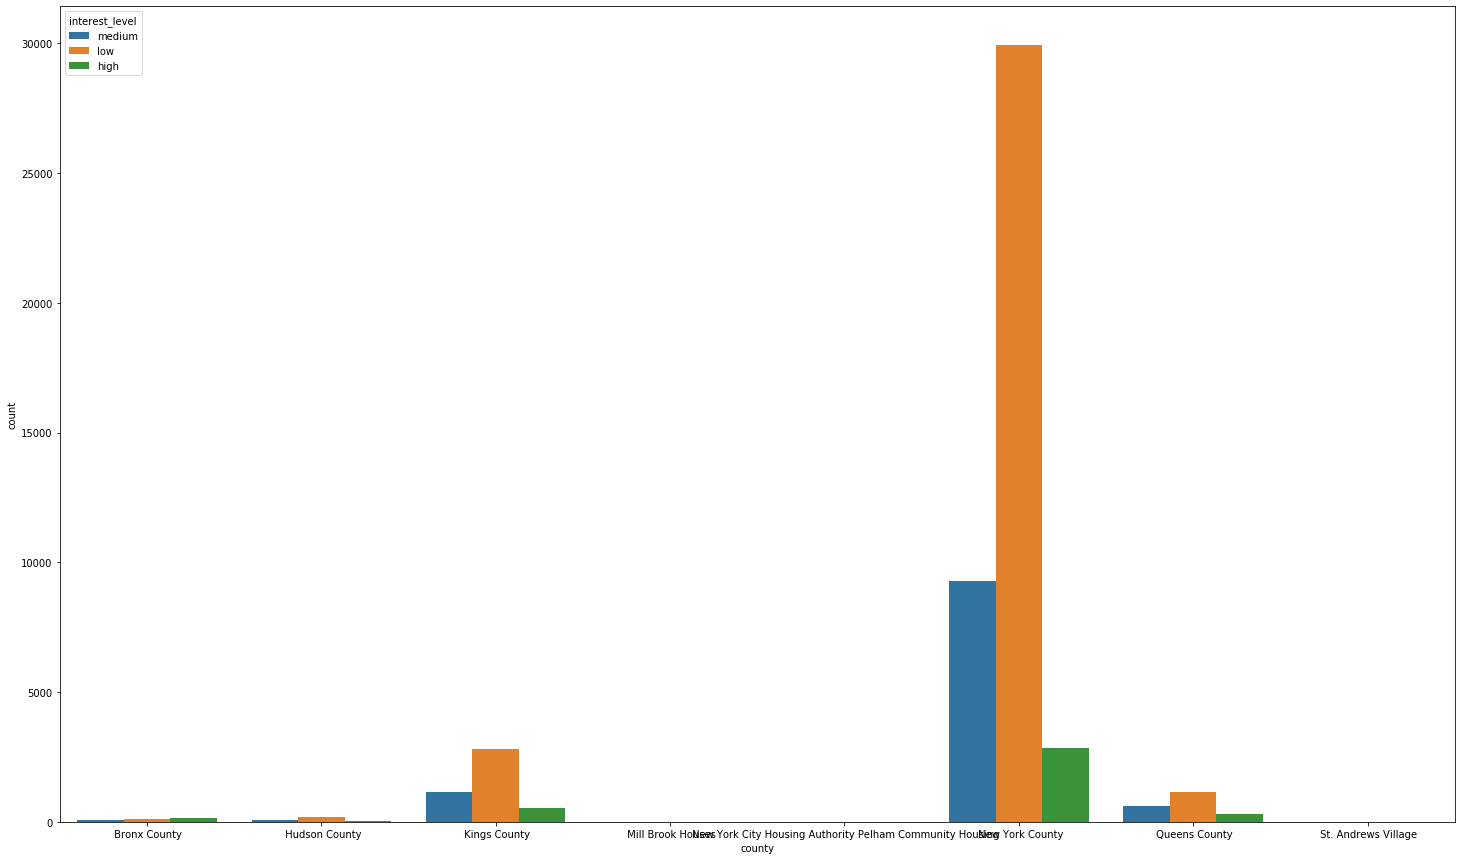

In [131]:
df['county'] = df['geolocation'].apply(lambda x: x[-4:][0])# apply counties as extra column

plt.figure(figsize=(25,15))
sns.countplot(df['county'].astype('category'), hue = df['interest_level'])
plt.show()

Does not seem so, also the number occurences for the New York County is really high, maybe we should look even further into this. But before that, let us also look at the postcodes.

<a id='section3.2'></a>

### 3.2 Postal Codes

In [132]:
df['postal'] = df['geolocation'].progress_apply(lambda x: x[-2:][0])

In [133]:
df['postal']= df['postal'].apply(lambda x: x.split(':')[0])
df['postal']= df['postal'].apply(lambda x: x.split('-')[0])

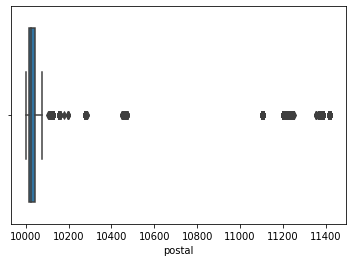

In [134]:
# weird postcodes

df['postal'] = pd.to_numeric(df['postal']) # because it is still string


df = df [(df['postal'] > 10000) & (df['postal'] < 100000)] # drop wrong postal codes, must be 5 signs

df['postal'] = (df['postal']) # make it category

sns.boxplot(df['postal'])


As we can see we are within New York, therefore these outliers are not eliminated. 

Maybe we should also look into the boroughs that are covered.

<a id='section3.3'></a>

### 3.3 Boroughs

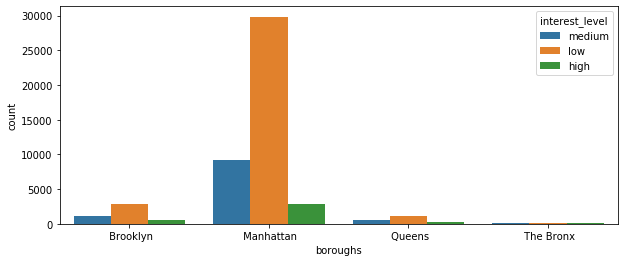

In [135]:
df['boroughs'] = df['geolocation'].apply(lambda x: x[-5:][0]) # set column for boroughs
# Drop others that include not the five boroughs that are in NYC
df = df[df['boroughs'].apply(lambda x : x in [' Manhattan', ' Staten Island', ' Queens', ' Brooklyn', ' The Bronx'])]
df['boroughs'] = df['boroughs'].astype('category') # make it categorical

plt.figure(figsize=(10,4))
sns.countplot(df['boroughs'], hue = df['interest_level'])
plt.show()

It seems that Manhattan has most of the entries. Maybe it would also be interesting to look into certain neighborhoods or communities within the city. These only apply for Manhattan, as these can be extracted from the geolocation. 

<a id='section3.4'></a>

### 3.4 Neighborhoods

In [136]:
# function to extract Manhatten communities
def ext_neighborhood(text):
    nb = re.findall(".*Board.*",text, re.MULTILINE) #regex to find every Manhattan board 
    return nb

In [137]:
df['neighborhood'] = 'other'
for row in df['geolocation'].index:
    for i in range(len(df['geolocation'][row])): 
        found = ext_neighborhood(df['geolocation'][row][i])
        if found != []:
            df['neighborhood'][row] = found[0]
            
        else:
            pass

In [138]:
df['neighborhood'].value_counts()

other                            9256
 Manhattan Community Board 8     7584
 Manhattan Community Board 6     6464
 Manhattan Community Board 7     4496
 Manhattan Community Board 1     4093
 Manhattan Community Board 4     4070
 Manhattan Community Board 5     3155
 Manhattan Community Board 2     3089
 Manhattan Community Board 3     2896
 Manhattan Community Board 12    1175
 Manhattan Community Board 9      951
 Manhattan Community Board 11     814
 Manhattan Community Board 10     805
Name: neighborhood, dtype: int64

<a id='section4'></a>

## 4. Parks and subways

What also could be of interest is the distance from the rented home to a park or subway which could increase the attractiveness for a certain home. For this we need to first check whether a park or subway was mentioned in the features or descriptions and then with the knowledge of the actual address of the home, we can calculate the distance to these options. We used the idea from the following kaggle book to integrate the steps into our notebook (see https://www.kaggle.com/chriscc/twosigmarenthop-advanced-feature-engineering).

Since we were not able to integrate the data of the distances to certain subway or park clusters, we simply created dummies for 'park' and 'subway' as follows:

In [140]:
df['park'] = 0
for row in df.index:
    if 'park' in str(df['description'][row]) or 'park' in str(df['features'][row]):
        df['park'][row] = 1
    elif 'Park' in str(df['description'][row]) or 'Park' in str(df['features'][row]):
        df['park'][row] = 1
    else:
        df['park'][row] = 0

In [141]:
df['subway'] = 0
for row in df.index:
    if 'subway' in str(df['description'][row]) or 'subway' in str(df['features'][row]):
        df['subway'][row] = 1
    elif 'Subway' in str(df['description'][row]) or 'Subway' in str(df['features'][row]):
        df['subway'][row] = 1
    else:
        df['subway'][row] = 0

In [144]:
X, y = df.drop(columns = [ 'building_id', 'created', 'description',
       'display_address', 'features', 'listing_id','manager_id',
        'photos',  'street_address', 'interest_level',
       'date_created','date_converted', 'weekday','cleaned_description',
        'features_lower', 'geo',
       'cleaned_features', 'geolocation', 'county', 'boroughs', 'postal', 'neighborhood']), df['interest_level']
rf = RandomForestClassifier(n_estimators=100,
                           n_jobs=-1,        # parallelize
                           oob_score=True)   # get error estimate
rf.fit(X, y)
clean_oob_r2 = rf.oob_score_
print(f"Validation OOB score {clean_oob_r2:.4f}")

Validation OOB score 0.7264


<a id='section5'></a>

## 5. Managers 

We also found following notebook regarding features of the managers column https://www.kaggle.com/den3b81/improve-perfomances-using-manager-features. Here, they calculate the fractions a specific manager is in the low, medium or high interest segment. For this they group the data by manager after getting dummies of the interest level. They also included the count how many times a manager is rsponsible for a listing. 

In [546]:
lbl = preprocessing.LabelEncoder()
lbl.fit(df['manager_id'].values)
df['manager_id'] = lbl.transform(df['manager_id'].values)

In [547]:
df['manager_id'].value_counts()

3128    2499
1496     704
1950     401
1336     396
2778     373
        ... 
3258       1
2349       1
396        1
428        1
1807       1
Name: manager_id, Length: 3474, dtype: int64

In [548]:
man = pd.concat([df.manager_id,pd.get_dummies(df['interest_level'])], axis = 1).groupby('manager_id').mean()
man.columns = ['high_frac','low_frac', 'medium_frac']
man['count'] = df.groupby('manager_id').count().iloc[:,1]
print(man.tail(10))

            high_frac  low_frac  medium_frac  count
manager_id                                         
3464         0.000000  0.666667     0.333333      3
3465         0.625000  0.250000     0.125000      8
3466         0.000000  1.000000     0.000000      1
3467         0.000000  1.000000     0.000000      1
3468         0.142857  0.714286     0.142857      7
3469         0.000000  1.000000     0.000000      1
3470         0.000000  1.000000     0.000000      7
3471         0.000000  1.000000     0.000000      2
3472         0.142857  0.714286     0.142857      7
3473         0.034783  0.669565     0.295652    115


From these fractions it is possible to evaluate the manager skill which was calculated in the exmaple as follows:

In [549]:
# compute skill
man['manager_skill'] = man['high_frac']*2 + man['medium_frac']
print(man)

            high_frac  low_frac  medium_frac  count  manager_skill
manager_id                                                        
0            0.000000  0.333333     0.666667     12       0.666667
1            0.000000  1.000000     0.000000     10       0.000000
2            0.000000  1.000000     0.000000      1       0.000000
3            0.000000  0.000000     1.000000      2       1.000000
4            0.000000  0.666667     0.333333      3       0.333333
...               ...       ...          ...    ...            ...
3469         0.000000  1.000000     0.000000      1       0.000000
3470         0.000000  1.000000     0.000000      7       0.000000
3471         0.000000  1.000000     0.000000      2       0.000000
3472         0.142857  0.714286     0.142857      7       0.428571
3473         0.034783  0.669565     0.295652    115       0.365217

[3474 rows x 5 columns]


They also ranked these managers then by their count later on. Managers that did not have a count over 20 were imputet with the values of the ranked managers. 

In [550]:
# get ixes for unranked managers...
unranked_managers_ixes = man['count']>20
# ... and ranked ones
ranked_managers_ixes = ~unranked_managers_ixes

# compute mean values from ranked managers and assign them to unranked ones
mean_values = man.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
print(mean_values)
man.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
print(man.tail(10))

high_frac        0.088391
low_frac         0.730429
medium_frac      0.181180
manager_skill    0.357962
dtype: float64
            high_frac  low_frac  medium_frac  count  manager_skill
manager_id                                                        
3464         0.000000  0.666667     0.333333      3       0.333333
3465         0.625000  0.250000     0.125000      8       1.375000
3466         0.000000  1.000000     0.000000      1       0.000000
3467         0.000000  1.000000     0.000000      1       0.000000
3468         0.142857  0.714286     0.142857      7       0.428571
3469         0.000000  1.000000     0.000000      1       0.000000
3470         0.000000  1.000000     0.000000      7       0.000000
3471         0.000000  1.000000     0.000000      2       0.000000
3472         0.142857  0.714286     0.142857      7       0.428571
3473         0.088391  0.730429     0.181180    115       0.357962


In [551]:
# inner join to assign manager features to the managers in the dataframe
df = df.merge(man.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
df.head(20)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,avg_price_postal,avg_price_boroughs,avg_price_county,sqrt_price,log_price,high_frac,low_frac,medium_frac,count,manager_skill
0,1,1,8579a0b0d54db803821a35a4a615e97a,1466056527000,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,86,2,5,48.989795,7.783224,0.088391,0.730429,0.181180,112,0.357962
1,1,2,b8e75fc949a6cd8225b455648a951712,1464759873000,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,112,3,6,61.644140,8.242756,0.088391,0.730429,0.181180,25,0.357962
2,1,2,cd759a988b8f23924b5a2058d5ab2b49,1465917599000,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,113,3,6,59.118525,8.159089,0.088391,0.730429,0.181180,90,0.357962
3,2,3,53a5b119ba8f7b61d4e010512e0dfc85,1466754864000,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,86,2,5,54.772256,8.006368,0.088391,0.730429,0.181180,90,0.357962
4,1,0,bfb9405149bfff42a92980b594c28234,1467085823000,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,...,109,3,6,52.867760,7.935587,0.088391,0.730429,0.181180,55,0.357962
5,1,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,1467093546000,This spectacular converted 3 bed apartment all...,East 16th Street,"[Doorman, Elevator, Loft, Dishwasher, Hardwood...",40.7348,7226687,-73.9865,...,119,3,6,84.852814,8.881836,0.088391,0.730429,0.181180,168,0.357962
6,3,3,0d01cabe55fa5192cdbcabd5c585c1ea,1465366896000,AMAZING DEAL!! BRAND NEW RENOVATIONS IN THIS H...,East 13th Street,"[Fireplace, Laundry in Unit, Dishwasher, Hardw...",40.7302,7126989,-73.9826,...,108,3,6,77.459667,8.699515,0.088391,0.730429,0.181180,161,0.357962
7,1,0,d48767c37a934daaf0bbb0e58c755d0c,1465104502000,No Fee Large Renovated Sun Splashed Studio. Wa...,York Avenue,"[Elevator, Laundry in Building, Dishwasher, Ha...",40.7769,7114138,-73.9467,...,89,3,6,44.102154,7.573017,0.088391,0.730429,0.181180,122,0.357962
8,0,1,d1ca33a2853e64fad6e4009d5d5d168f,1465447323000,Extra large one bedroom apartment located in P...,E 19 Street,[Hardwood Floors],40.7346,7131094,-73.9811,...,119,3,6,49.345719,7.797702,0.088391,0.730429,0.181180,35,0.357962
9,5,3,5f35dc2f0191baf109221752e6ee0c48,1467084378000,Listed: 06/26/16<br /><br />Available:...,Hicks Street,"[Cats Allowed, Dogs Allowed]",40.6990,7224815,-73.9943,...,94,2,5,82.764727,8.832004,0.088391,0.730429,0.181180,36,0.357962


In [552]:
X, y = df.drop(columns = [ 'building_id', 'created', 'description',
       'display_address', 'features', 'listing_id','manager_id',
        'photos',  'street_address', 'interest_level',
       'date_created','date_converted', 'weekday','cleaned_description',
        'features_lower', 'geo',
       'cleaned_features', 'geolocation', 'county', 'boroughs', 'postal', 'neighborhood']), df['interest_level']
rf = RandomForestClassifier(n_estimators=100,
                           n_jobs=-1,        # parallelize
                           oob_score=True)   # get error estimate
rf.fit(X, y)
clean_oob_r2 = rf.oob_score_
print(f"Validation OOB score {clean_oob_r2:.4f}")

Validation OOB score 0.7504


<a id='section6'></a>

## 6. **Interactions**

Since we assume that price has a high impact on the interest level, maybe there are some features that interact with price, such as rooms or the location. In the following we created several interactions and features that include 'price'. 

In [526]:
df["price_type"] = np.log(df["price"])/(df["bedrooms"].astype('int64')+1) 
df["room_sum"] = df["bedrooms"].astype('int64')+df["bathrooms"].astype('int64') 

df['price_per_room'] = 0.0
for row in df.index:
    if df['room_sum'][row] > 0:
        df['price_per_room'][row]= (df['price'][row])/(df['room_sum'][row])
    else:
        pass

In [527]:
group = df.groupby('neighborhood').mean()
group = group['price']

In [528]:
df['avg_price_hood'] = 0.0
# integrating average price of neighborhoods to dataframe
for row in df['neighborhood'].index:
    for hood in group.index:
        if df['neighborhood'][row] == hood:
            df['avg_price_hood'][row] = group[hood]

In [529]:
group = df.groupby('postal').mean()
group = group['price']

In [530]:
df['avg_price_postal'] = 0.0
# integrating average price of neighborhoods to dataframe
for row in df['postal'].index:
    for hood in group.index:
        if df['postal'][row] == hood:
            df['avg_price_postal'][row] = group[hood]

In [531]:
group = df.groupby('boroughs').mean()
group = group['price']

In [532]:
df['avg_price_boroughs'] = 0.0
# integrating average price of neighborhoods to dataframe
for row in df['boroughs'].index:
    for hood in group.index:
        if df['boroughs'][row] == hood:
            df['avg_price_boroughs'][row] = group[hood]

In [533]:
group = df.groupby('county').mean()
group = group['price']

In [534]:
df['avg_price_county'] = 0.0
# integrating average price of neighborhoods to dataframe
for row in df['county'].index:
    for hood in group.index:
        if df['county'][row] == hood:
            df['avg_price_county'][row] = group[hood]

<a id='section7'></a>

## 7. **Transforming 'price'**

As we've seen the price is right-skewed. Therefore we need to transform the data to normalize it's values. For this we read the article from StatistikGuru: https://statistikguru.de/spss/vorraussetzungen-ueberpruefen/daten-transformieren/bekannte-datentransformationen.html. 

In [602]:
df['sqrt_price'] = np.sqrt(df['price']) 

In [603]:
df['log_price']= np.log(df['price'])

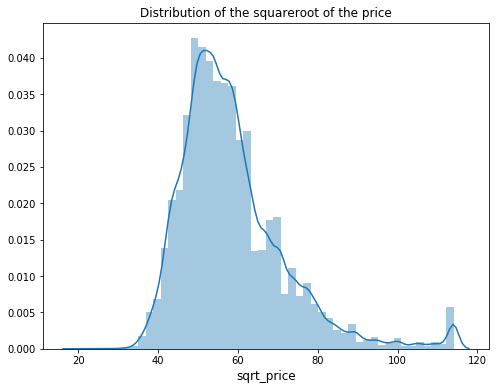

In [607]:
plt.figure(figsize=(8,6))
sns.distplot(df.sqrt_price.values, bins=50, kde=True)
plt.xlabel('sqrt_price', fontsize=12)
plt.title('Distribution of the squareroot of the price')
plt.show()

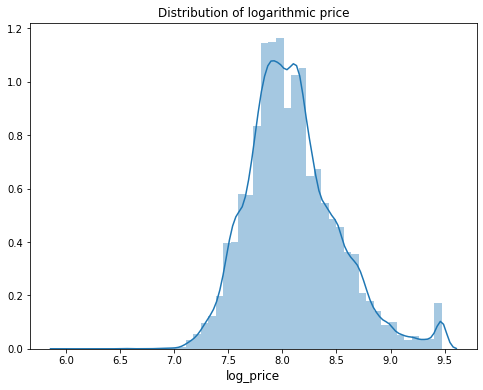

In [606]:
plt.figure(figsize=(8,6))
sns.distplot(df.log_price.values, bins=50, kde=True)
plt.xlabel('log_price', fontsize=12)
plt.title('Distribution of logarithmic price')
plt.show()

In [538]:
print("Skewness: " , sqrt.skew())
print("Kurtosis: " , sqrt.kurt())

Skewness:  1.5014324068868452
Kurtosis:  3.3470467113461564


In [539]:
print("Skewness: " , log.skew())
print("Kurtosis: " , log.kurt())

Skewness:  0.6933924223557091
Kurtosis:  0.855952673549949


We can now see that the logarithmic price is closer to the normal distribution. Maybe we should consider that price.

In [540]:
X, y = df.drop(columns = [ 'building_id', 'created', 'description',
       'display_address', 'features', 'listing_id','manager_id',
        'photos',  'street_address', 'interest_level',
       'date_created','date_converted', 'weekday','cleaned_description',
        'features_lower', 'geo',
       'cleaned_features', 'geolocation', 'county', 'boroughs', 'postal', 'neighborhood']), df['interest_level']
rf = RandomForestClassifier(n_estimators=100,
                           n_jobs=-1,        # parallelize
                           oob_score=True)   # get error estimate
rf.fit(X, y)
clean_oob_r2 = rf.oob_score_
print(f"Validation OOB score {clean_oob_r2:.4f}")

Validation OOB score 0.7347


<a id='section8'></a>

## 8. **Finalizing the data and preparation for modeling**

For now we were only able to use numerical data, but let us transform also our categorical features so that the model can read them in.

In [17]:
df.columns

Index(['bathrooms', 'bedrooms', 'manager_id', 'interest_level', 'high_priced',
       'date_created', 'date_converted', 'weekday', 'hour_created', 'month',
       'dayofmonth', 'num_redacted', 'room_sum', 'phone', 'email',
       'neighborhood', 'postal', 'boroughs', 'county', 'geo', 'subway', 'park',
       'latitude', 'longitude', 'price', 'num_photos', 'num_features',
       'num_description', 'len_cleaned_description', 'similarity_address',
       'dining_room', 'pre_war', 'laundry_in_building', 'dishwasher',
       'hardwood_floors', 'dogs_allowed', 'cats_allowed', 'doorman',
       'elevator', 'no_fee', 'laundry_in_unit', 'fitness_center', 'loft',
       'fireplace', 'roof_deck', 'high_speed_internet', 'swimming_pool',
       'wheelchair_access', 'reduced_fee', 'common_outdoor_space',
       'parking_space', 'balcony', 'private_outdoor_space', 'publicoutdoor',
       'garage', 'garden', 'patio', 'new_construction', 'furnished',
       'exclusive', 'terrace', 'outdoor_space', 'liv

In [18]:
cat = ['bathrooms', 'bedrooms', 'manager_id', 'interest_level', 'high_priced',
       'date_created', 'date_converted', 'weekday', 'hour_created', 'month',
       'dayofmonth', 'num_redacted', 'room_sum', 'phone', 'email',
       'neighborhood', 'postal', 'boroughs', 'county', 'subway', 'park','geo', 
       ]


In [19]:
from sklearn.preprocessing import LabelEncoder # tranform categorical variables 
labelencoder = LabelEncoder()

    
# Encode labels of multiple columns at once
df[cat] = df[cat].apply(labelencoder.fit_transform)

In [20]:
nums = ['latitude', 'longitude', 'price', 'num_photos', 'num_features',
       'num_description', 'len_cleaned_description', 'similarity_address',
       'dining_room', 'pre_war', 'laundry_in_building', 'dishwasher',
       'hardwood_floors', 'dogs_allowed', 'cats_allowed', 'doorman',
       'elevator', 'no_fee', 'laundry_in_unit', 'fitness_center', 'loft',
       'fireplace', 'roof_deck', 'high_speed_internet', 'swimming_pool',
       'wheelchair_access', 'reduced_fee', 'common_outdoor_space',
       'parking_space', 'balcony', 'private_outdoor_space', 'publicoutdoor',
       'garage', 'garden', 'patio', 'new_construction', 'furnished',
       'exclusive', 'terrace', 'outdoor_space', 'live', 'site_laundry',
       'prewar', 'lowrise', 'simplex', 'hardwood', 'washer', 'pool', 'storage',
       'laundry', 'multi_level', 'high_ceilings', 'high_ceiling',
       'laundry_room', 'renovated', 'dryer_in_unit', 'live_in_super',
       'green_building', 'price_type', 'price_per_room', 'avg_price_hood',
       'avg_price_postal', 'avg_price_boroughs', 'avg_price_county',
       'high_frac', 'low_frac', 'medium_frac', 'manager_skill', 'log_price',
       'sqrt_price']



Standardization is necessary for numerical data since our model assumes that the train data is normally distributed but if it is not, we risk biasing our model. We need to check the variance and if it is high, standardization is important.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
nums_scaled = pd.DataFrame(scaler.fit_transform(df[nums]), columns=df[nums].columns)

In [22]:
df_final = pd.concat([df[cat],nums_scaled], axis = 1) #concatenate again

In [23]:
#Check variance

print(df_final.var())

bathrooms         8.514965e-01
bedrooms          1.243837e+00
manager_id        1.007807e+06
interest_level    2.830380e-01
high_priced       9.669828e-03
                      ...     
low_frac          1.000020e+00
medium_frac       1.000020e+00
manager_skill     1.000020e+00
log_price         1.000020e+00
sqrt_price        1.000020e+00
Length: 92, dtype: float64


In [24]:
df_final = pd.concat([df[cat],nums_scaled], axis = 1) #concatenate again

Throughout the engineering we could see that the OOB score is steadily increasing as seen below. We have now prepared our data to use for the modeling and therefore need to save it. 

In [25]:
X, y = df_final.drop(columns = [ 'interest_level']), df_final['interest_level']
rf = RandomForestClassifier(n_estimators=100,
                           n_jobs=-1,        # parallelize
                           oob_score=True)   # get error estimate
rf.fit(X, y)
clean_oob_r2 = rf.oob_score_
print(f"Validation OOB score {clean_oob_r2:.4f}")

Validation OOB score 0.7513


In [ ]:
#df_final.to_json('feature_engineering.json')